In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
import cv2
import os
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.utils.vis_utils import plot_model


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings


from helpers import process_data, compose_dataset, plot_training, metrics

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# The Data

## Summary
To explain the labels and counts of the dataset (metadata)

In [3]:
DATASET_DIR = "data/data_image.csv"

<IPython.core.display.Javascript object>

In [4]:
dataset = pd.read_csv(DATASET_DIR)

<IPython.core.display.Javascript object>

## The information about the dataset

### Load the data

In [5]:
%%time
IMAGE_RESOLUTION = (224, 224, 1)
BORDER = 30
IMG_FORMAT = (IMAGE_RESOLUTION[0]-2*BORDER,IMAGE_RESOLUTION[1]-2*BORDER, 1)
print('Image shape: {}'.format(IMG_FORMAT))


# Creating dataset
train_set = dataset[dataset.kind == "train"][["full_path", "flag"]]
test_set = dataset[dataset.kind == "test"][["full_path", "flag"]]
val_set = dataset[dataset.kind == "val"][["full_path", "flag"]]

# Creating X and y variables
X_train, y_train = compose_dataset(train_set, IMAGE_RESOLUTION ,BORDER)
X_test, y_test = compose_dataset(test_set, IMAGE_RESOLUTION ,BORDER)
X_val, y_val = compose_dataset(val_set, IMAGE_RESOLUTION ,BORDER)

# Infortmations
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Image shape: (164, 164, 1)
Train data shape: (5216, 164, 164, 1), Labels shape: (5216,)
Test data shape: (624, 164, 164, 1), Labels shape: (624,)
Validation data shape: (16, 164, 164, 1), Labels shape: (16,)
Wall time: 1min 13s


<IPython.core.display.Javascript object>

### Examples

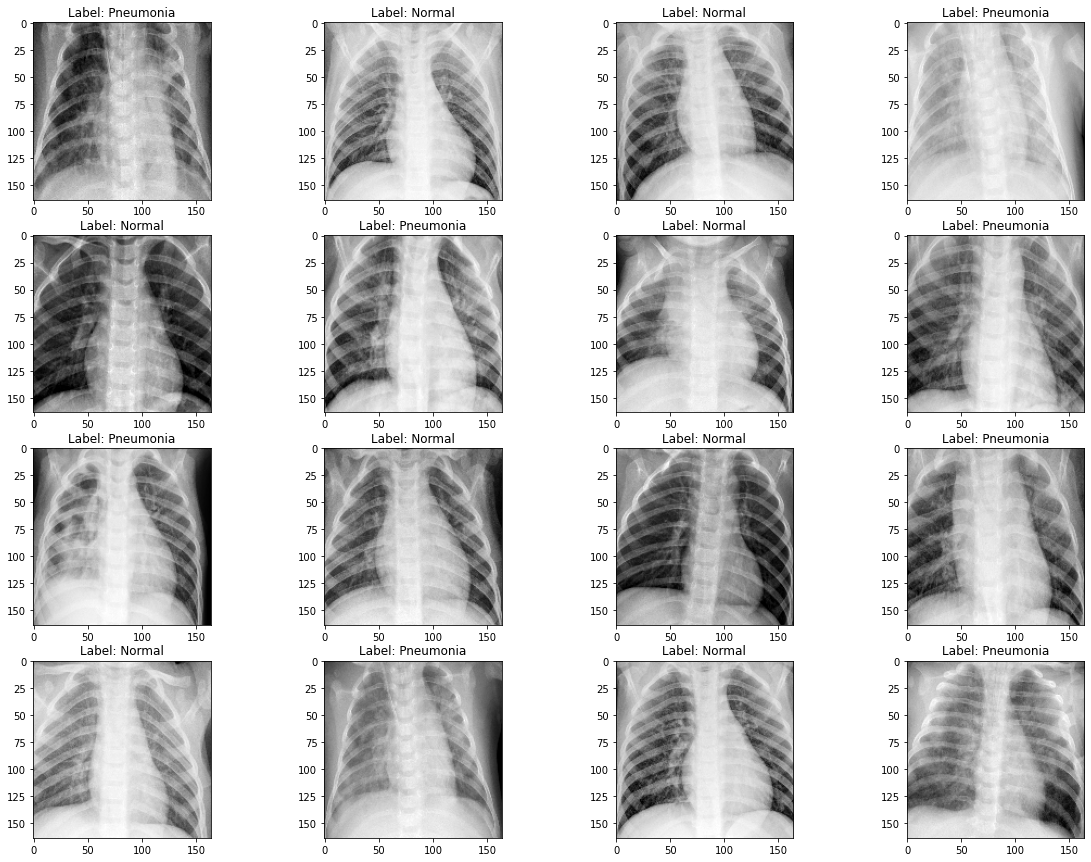

<IPython.core.display.Javascript object>

In [6]:
labels = ["Pneumonia" if y else "Normal" for y in y_val]
plt.figure(figsize=(20, 15))
for i, x in enumerate(X_val):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x.reshape(IMG_FORMAT[:2]), cmap="gray")
    plt.axis("on")
    plt.title("Label: {}".format(labels[i]))

### ImageDataGenerator

In [7]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=False,
    vertical_flip=False,
)

# fit generator on our train features
datagen.fit(X_train)

<IPython.core.display.Javascript object>

# Model

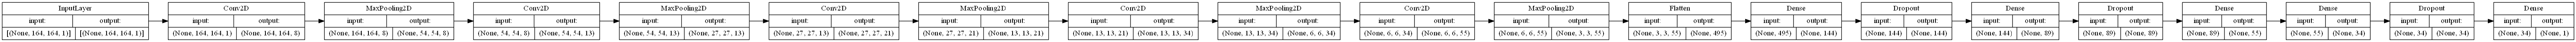

<IPython.core.display.Javascript object>

In [8]:
# Imports
from models.cnn5_ann5_fibonacci_adam.model import cnn5_ann5_fibonacci_adam
from models.cnn6_ann3_pow10_adamax.model import cnn6_ann3_pow10_adamax
from models.cnn10_ann2_pow2_adam.model import cnn10_ann2_pow2_adam


# Models
model = cnn5_ann5_fibonacci_adam(IMG_FORMAT)

# Will be used to save model and plots
model_path = "models\\cnn5_ann5_fibonacci_adam"

# Saving the model's plot
plot_model(
    model,
    to_file=model_path + "\model_plot.png",
    show_shapes=True,
    show_layer_names=False,
    dpi=100,
    rankdir="LR",
)

### Training

In [9]:
%%time

callback = EarlyStopping(monitor="loss", patience=3)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    validation_data=(X_test, y_test),
    epochs=100,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/100
1044/1044 [==============================] - 15s 12ms/step - loss: 0.5986 - accuracy: 0.7346 - val_loss: 0.6933 - val_accuracy: 0.6250
Epoch 2/100
1044/1044 [==============================] - 11s 10ms/step - loss: 0.5794 - accuracy: 0.7377 - val_loss: 0.6753 - val_accuracy: 0.6250
Epoch 3/100
1044/1044 [==============================] - 10s 10ms/step - loss: 0.5706 - accuracy: 0.7463 - val_loss: 0.6832 - val_accuracy: 0.6250
Epoch 4/100
1044/1044 [==============================] - 11s 10ms/step - loss: 0.5128 - accuracy: 0.7604 - val_loss: 0.5030 - val_accuracy: 0.7356
Epoch 5/100
1044/1044 [==============================] - 11s 11ms/step - loss: 0.3754 - accuracy: 0.8250 - val_loss: 0.4101 - val_accuracy: 0.8205
Epoch 6/100
1044/1044 [==============================] - 11s 11ms/step - loss: 0.3325 - accuracy: 0.8535 - val_loss: 0.3740 - val_accuracy: 0.8462
Epoch 7/100
1044/1044 [==============================] - 12s 11ms/step - loss: 0.3128 - accuracy: 0.8611 - val_loss: 0

<IPython.core.display.Javascript object>

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 164, 164, 8)       400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 13)        949       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 13)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 21)        2478      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 21)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 34)        6

<IPython.core.display.Javascript object>

### Metrics

In [11]:
y_pred = model.predict(X_test, batch_size=4)
y_pred_class = y_pred.round()

plot_training(history, model_path)
metrics(
    y_test,
    y_pred.reshape(1, -1)[0],
    y_pred_class.reshape(1, -1)[0].astype(int),
    model_path,
)

<IPython.core.display.Javascript object>

### Just to Save

In [12]:
model.save(model_path + "\model")

INFO:tensorflow:Assets written to: models\cnn5_ann5_fibonacci_adam\model\assets


<IPython.core.display.Javascript object>

# Explainability of Artificial Inteligence XAI

Explainable AI (XAI) is artificial intelligence (AI) in which the results of the solution can be understood by humans. It contrasts with the concept of the "black box" in machine learning where even its designers cannot explain why an AI arrived at a specific decision. XAI may be an implementation of the social right to explanation.

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [13]:
labels = ["Pneumonia" if y else "Normal" for y in y_val]
labels = pd.DataFrame(labels, columns=["Labels"])
predictions = model.predict(X_val).round().reshape(-1, 1).astype(int)
labels["Predictions"] = ["Pneumonia" if y else "Normal" for y in predictions]
labels["Print Real - Predicted"] = labels["Labels"].str.cat(
    labels["Predictions"], sep=" - "
)
labels_to_print = labels["Print Real - Predicted"].values.reshape(-1, 1)
labels

Labels Predictions Print Real - Predicted
0   Pneumonia   Pneumonia  Pneumonia - Pneumonia
1      Normal   Pneumonia     Normal - Pneumonia
2      Normal   Pneumonia     Normal - Pneumonia
3   Pneumonia   Pneumonia  Pneumonia - Pneumonia
4      Normal      Normal        Normal - Normal
5   Pneumonia   Pneumonia  Pneumonia - Pneumonia
6      Normal   Pneumonia     Normal - Pneumonia
7   Pneumonia   Pneumonia  Pneumonia - Pneumonia
8   Pneumonia   Pneumonia  Pneumonia - Pneumonia
9      Normal   Pneumonia     Normal - Pneumonia
10     Normal      Normal        Normal - Normal
11  Pneumonia   Pneumonia  Pneumonia - Pneumonia
12     Normal      Normal        Normal - Normal
13  Pneumonia   Pneumonia  Pneumonia - Pneumonia
14     Normal   Pneumonia     Normal - Pneumonia
15  Pneumonia   Pneumonia  Pneumonia - Pneumonia

<IPython.core.display.Javascript object>

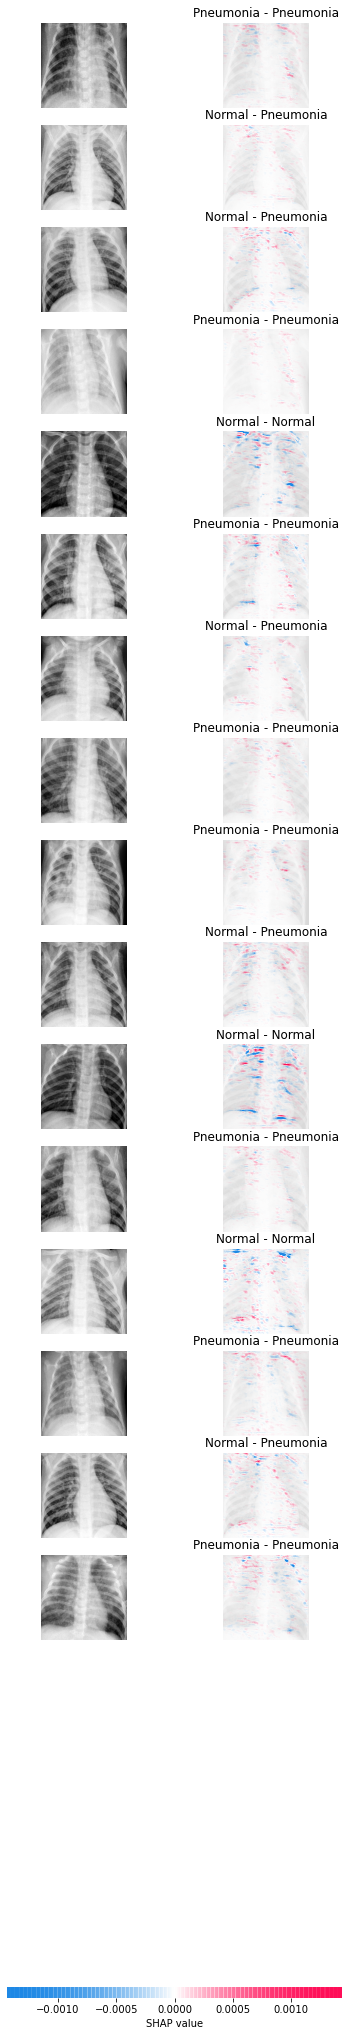

<IPython.core.display.Javascript object>

In [14]:
e = shap.DeepExplainer(model, X_val)
shap_values = e.shap_values(X_val)
fig = shap.image_plot(shap_values, X_val, labels_to_print, show=False)
plt.savefig(model_path + "\shap.jpeg")